# Introduction

In this project, we will be working with data from the S&P500 Index. The S&P500 is a stock market index. Before we get into what an index is, we'll need to get into the basics of the stock market.

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company, and to some percentage (or share) of the earnings of the company. When we buy or sell shares, it's common to say that we are trading a stock.

The price of a share is based mainly on supply and demand for a given stock. For example, Apple stock has a price of 120 dollars per share as of December 2015 -- http://www.nasdaq.com/symbol/aapl. A stock that is in less demand, like Ford Motor Company, has a lower price -- http://finance.yahoo.com/q?s=F. Stock price is also influenced by other factors, including the number of shares a company has issued.

Stocks are traded daily, and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow us to see how the market as a whole is performing. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, we can say that the underlying market or sector it represents is also going up or down. For example, if the Dow Jones Industrial Average price goes down one day, we can say that American stocks overall went down (ie, most American stocks went down in price).

we will be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

In [37]:
# Importing Resources

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from time import time

import visuals as vs

import warnings
warnings.filterwarnings('ignore')

# Exploring the Data

In [2]:
# Creating a dataframe of the S&P500 dataset

df = pd.read_csv('sphist.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


We can see that the dataset has several columns which are:

- **Date**: The date of the record.


- **Open**: The opening price of the day (when trading starts).


- **High**: The highest trade price during the day.


- **Low**: The lowest trade price during the day.


- **Close**: The closing price for the day (when trading is finished).


- **Volume**: The number of shares traded.


- **Adj Close**: The daily closing price, adjusted retroactively to include any corporate actions. 

All the prices are in American Dollars $. In this problem, we will be using the **Close** column as the target (The value we are trying to predict). 

In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

In [5]:
# Sort data in descending order

df = df.sort_values(by='Date')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


## Generating Indicators to assist in making accurate predictions

In [6]:
# Average price of the past 5, 30 and 365 days
day_5 = df["Close"].rolling(5).mean().shift(1)
day_30 = df["Close"].rolling(30).mean().shift(1)
day_365 = df["Close"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
ratio_5_to_365 = day_5 / day_365

# Standard deviation of the past 5 and 365 days
day_5_std = df["Close"].rolling(5).std().shift(1)
day_365_std = df["Close"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
ratio_std_5_to_365 = day_5_std / day_365_std

# Add to main dataframe

df['day_5'] = day_5
df['day_30'] = day_30
df['day_365'] = day_365
df['ratio_5_to_365'] = ratio_5_to_365
df['day_5_std'] = day_5_std
df['day_365_std'] = day_365_std
df['ratio_std_5_to_365'] = ratio_std_5_to_365

# Test Different Supervised Learning Models

In [8]:
features = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365']

df = df.dropna(axis=0)

train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

x_train = train[features]
y_train = train["Close"]

x_test = test[features]
y_test = test["Close"]

def train_predict(learner, x_train, y_train, x_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(x_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test)
    # then get predictions on the training set
    start = time() # Get start time
    predictions_test = learner.predict(x_test)
    predictions_train = learner.predict(x_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute rmse on train set
    mse_train = mean_squared_error(y_train,predictions_train)
    results['rmse_train'] = np.sqrt(mse_train)
        
    # Compute rmse on test set
    mse_test = mean_squared_error(y_test, predictions_test)
    results['rmse_test'] = np.sqrt(mse_test)
    
    # Compute mae on train set
    results['mae_train'] = mean_absolute_error(y_train,predictions_train)
        
    # Compute mae on test set
    results['mae_test'] = mean_absolute_error(y_test, predictions_test)
       
    # Success
    print("{} has been trained".format(learner.__class__.__name__))
        
    # Return the results
    return results

In [ ]:
def evaluate(results):
    """
    Visualization code to display results of various learners.

    inputs:
      - results: Dictionary including stats from different learners
    """

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 9))

    # Constants
    bar_width = 0.45
    colors = ['#A00000', '#00A0A0', '#00A000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'rmse_train', 'mae_train', 'pred_time', 'rmse_test', 'mae_test']):
            # Creative plot code
            ax[j // 3, j % 3].bar(k + bar_width, results[learner][metric], width=bar_width, color=colors[k])

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("RMSE (in $)")
    ax[0, 2].set_ylabel("MAE (in $)")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("RMSE (in $)")
    ax[1, 2].set_ylabel("MAE (in $)")

    # Hide x-axis
    ax[0, 0].tick_params(bottom=False)
    ax[0, 0].set(xticklabels=[])
    ax[0, 1].tick_params(bottom=False)
    ax[0, 1].set(xticklabels=[])
    ax[0, 2].tick_params(bottom=False)
    ax[0, 2].set(xticklabels=[])
    ax[1, 0].tick_params(bottom=False)
    ax[1, 0].set(xticklabels=[])
    ax[1, 1].tick_params(bottom=False)
    ax[1, 1].set(xticklabels=[])
    ax[1, 2].tick_params(bottom=False)
    ax[1, 2].set(xticklabels=[])

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("RMSE on Training Subset")
    ax[0, 2].set_title("MAE on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("RMSE on Testing Set")
    ax[1, 2].set_title("MAE on Testing Set")

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color=colors[i], label=learner))
    plt.legend(handles=patches, bbox_to_anchor=(-.80, 2.53), \
               loc='upper center', borderaxespad=0., ncol=3, fontsize='x-large')

    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize=16, y=1.10)
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor has been trained


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR has been trained
LinearRegression has been trained


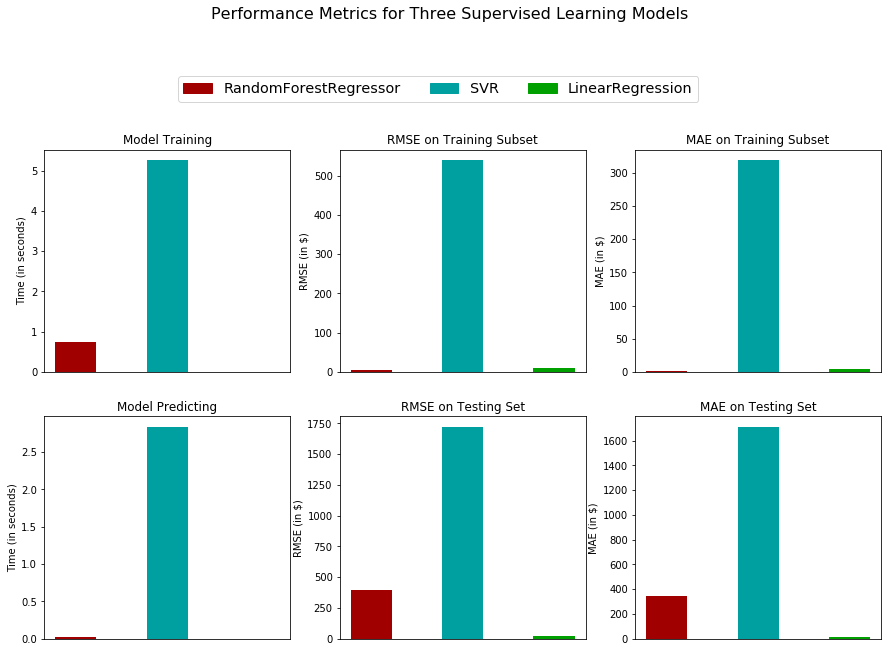

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

reg_A = RandomForestRegressor(random_state=42)
reg_B = SVR()
reg_C = LinearRegression()

# Collect results on the learners
results = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results[reg_name] = train_predict(reg, x_train, y_train, x_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# evaluate(results)
evaluate(results)

In [30]:
def lr_train_test(df, features):
    
    df = df.dropna(axis=0)

    train= df[df["Date"] < datetime(year=2013, month=1, day=1)]
    test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

    lr = LinearRegression()

    lr.fit(train[features], train["Close"])

    predictions = lr.predict(test[features])

    mae = mean_absolute_error(test['Close'], predictions)

    mse = mean_squared_error(test['Close'], predictions)
    rmse = np.sqrt(mse)
    
    print("The MAE is {:.2f}, and the RMSE is {:.2f}".format(mae, rmse))
    
    return lr, predictions

In [31]:
# First go
lr_train_test(df, features)

The MAE is 16.15, and the RMSE is 22.20


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 array([1419.35266255, 1425.50430495, 1433.37832166, 1443.35927575,
        1457.0539429 , 1464.86735201, 1464.45835352, 1466.79323606,
        1467.74152702, 1469.48368712, 1472.82335205, 1475.58274974,
        1476.96476026, 1479.51381479, 1483.79260424, 1488.38935506,
        1493.23848087, 1497.77799531, 1500.82796465, 1503.7716206 ,
        1505.19202129, 1505.85490598, 1507.62976   , 1506.43953166,
        1506.95416638, 1508.87875431, 1511.23045863, 1511.92566544,
        1516.70941377, 1518.14268363, 1519.6808545 , 1522.37386362,
        1522.6555737 , 1525.15882738, 1523.25745595, 1518.93758423,
        1517.60935612, 1510.19806116, 1503.36678896, 1504.03404142,
        1506.46695754, 1506.87062402, 1515.05144274, 1524.08709042,
        1529.21938333, 1535.50377996, 1542.59949283, 1549.35853089,
        1552.03320965, 1554.86614319, 1558.76345727, 1560.6832945 ,
        1559.64954467, 1558.531581

In [ ]:
# Average volume of the past 5, 30 and 365 days
volume_5 = df["Volume"].rolling(5).mean().shift(1)
volume_30 = df["Volume"].rolling(30).mean().shift(1)
volume_365 = df["Volume"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
volume_5_to_365 = volume_5 / volume_365

# Standard deviation of the past 5 and 365 days
volume_5_std = df["Volume"].rolling(5).std().shift(1)
volume_365_std = df["Volume"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
volume_std_5_to_365 = volume_5_std / volume_365_std

# Add to main dataframe

df['volume_5'] = volume_5
df['volume_30'] = volume_30
df['volume_365'] = volume_365
df['volume_5_to_365'] = volume_5_to_365
df['volume_5_std'] = volume_5_std
df['volume_365_std'] = volume_365_std
df['volume_std_5_to_365'] = volume_std_5_to_365

In [34]:
features_updated = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365',
           'volume_5', 'volume_30', 'volume_365', 'volume_5_to_365', 'volume_5_std',
            'volume_365_std', 'volume_std_5_to_365']

lr_train_test(df, features_updated)

The MAE is 16.00, and the RMSE is 22.22


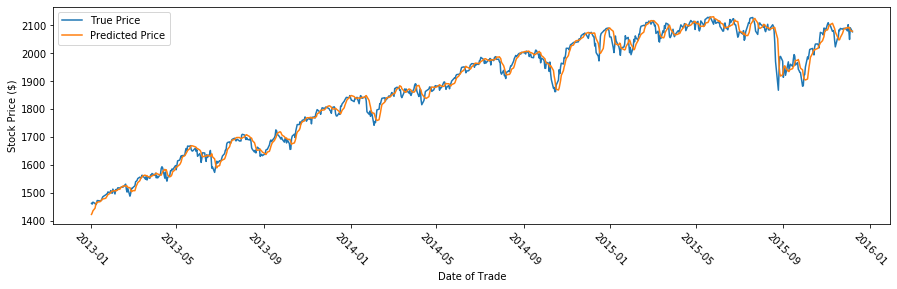

In [23]:
plt.figure(figsize=(15,4))

plt.plot(test['Date'], test['Close'], label='True Price')
plt.plot(test['Date'], predictions, label='Predicted Price')

plt.ylabel("Stock Price ($)")
plt.xlabel("Date of Trade")

plt.xticks(rotation=-45)

plt.legend()
plt.show()

Feature: day_5, Score: 1.06233
Feature: day_30, Score: -0.06314
Feature: day_365, Score: -0.00087
Feature: ratio_5_to_365, Score: -1.41969
Feature: day_5_std, Score: -0.09365
Feature: day_365_std, Score: 0.02705
Feature: ratio_std_5_to_365, Score: 0.49210
Feature: volume_5, Score: -0.00000
Feature: volume_30, Score: 0.00000
Feature: volume_365, Score: 0.00000
Feature: volume_5_to_365, Score: 1.57547
Feature: volume_5_std, Score: 0.00000
Feature: volume_365_std, Score: -0.00000
Feature: volume_std_5_to_365, Score: -0.19273


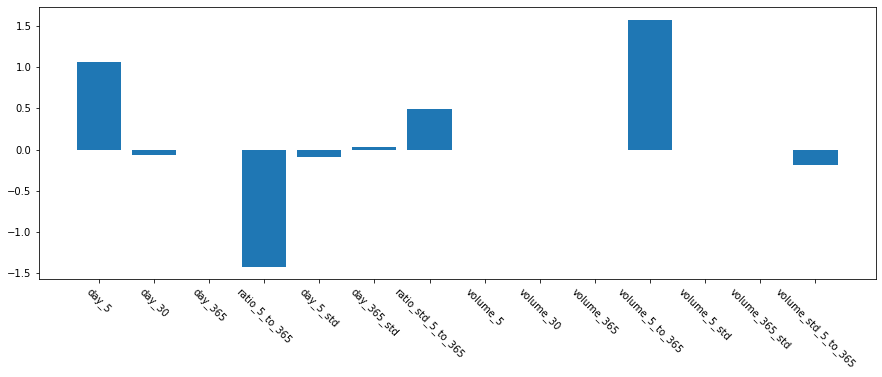

In [15]:
importance = lr.coef_

for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (features_updated[i],v))
# plot feature importance
fig = plt.figure(figsize = (15,5))
plt.bar(features_updated, importance)
plt.xticks(rotation=-45)
plt.show()

In [25]:
features_reduced = ['day_5', 'ratio_5_to_365', 'day_5_std', 'ratio_std_5_to_365',
                    'volume_5_to_365','volume_std_5_to_365']

df = df.dropna(axis=0)

train_updated = df[df["Date"] < datetime(year=2013, month=1, day=1)]
test_updated = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

lr = LinearRegression()

lr.fit(train_updated[features_reduced], train_updated["Close"])

predictions = lr.predict(test_updated[features_reduced])

mae = mean_absolute_error(test_updated['Close'], predictions)

mse = mean_squared_error(test_updated['Close'], predictions)
rmse = np.sqrt(mse)

print(mae)
print(rmse)

16.1292236670945
22.133950208537758


In [ ]:
test_dates = df[df["Date"] >= datetime(year=2013, month=1, day=1)]["Date"]

print(test_dates)

In [ ]:
def train_test(df, features, date):
    train_df  = df[df["Date"] < date]
    test_df = df[df["Date"] == date]
    
    #initialize model
    lr = LinearRegression()
    target = 'Close'

    #Train
    lr.fit(train_df[features], train_df[target])

    #Test
    prediction = lr.predict(test_df[features])
    
    mae = mean_absolute_error(test_df[target], prediction)
#     mse = mean_squared_error(test[target], prediction)
#     rmse = np.sqrt(mse)
    return mae

In [ ]:
maes = test_dates.apply(lambda date: train_test(df,features,date))

In [ ]:
mae = np.mean(maes)

# mse = np.sqrt(mse)

mae

In [ ]:
# plt.plot(test['Date'], test['Close'], label='True Price')
# plt.plot(test['Date'], predictions, label='Predicted Price')

# plt.xticks(rotation=-45)

# plt.legend()
# plt.show()

In [ ]:
# def train_test(df, features, model):
#     df = df.dropna(axis=0)
    
#     train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
#     test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

#     model.fit(train[features], train['Close'])

#     predictions = model.predict(test[features])

#     mae = mean_absolute_error(test['Close'], predictions)

#     mse = mean_squared_error(test['Close'], predictions)
#     rmse = np.sqrt(mse)
    
#     return rmse, mae